In [1]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv("E:\\leonhardt\\mayi\\data\\train.csv")

KeyboardInterrupt: 

In [2]:
df_train=df_train.loc[df_train['label']!=-1]
count = df_train.describe().loc["count"]

In [3]:
col_null = count.sort_values().index[:12]

In [4]:
df_train.drop(col_null, axis=1, inplace=True)

In [5]:
df_train.loc[:, "date"].max()

20171105

In [6]:
df_train.loc[:, "date"].min()

20170905

In [7]:
df_train.dropna(thresh=100, inplace=True)

In [8]:
df_train.describe()

,label,date,f1,f2,f3,f4,f5,f6,f7,f8,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
count,859199.000000,8.591990e+05,859199.000000,859199.000000,859199.000000,859199.000000,791632.000000,859199.000000,859199.000000,859199.000000,...,783971.000000,783971.000000,783971.000000,783971.000000,783971.000000,783971.000000,783971.000000,783971.000000,783971.000000,783971.000000
mean,0.008203,2.017098e+07,0.607969,0.501113,0.576794,0.500608,100650.241535,0.511502,4.304365,1.403904,...,159.352675,164.243554,173.978341,57.588783,149.331654,104.939758,105.126756,105.129363,41.213852,98.908017
std,0.090198,6.028784e+01,0.588674,0.500420,0.567156,0.500000,4002.892038,0.531374,1.860024,0.579801,...,149.137901,152.237610,164.134592,63.125896,142.629036,100.006813,100.159532,100.157312,45.663087,96.237474
min,0.000000,2.017090e+07,0.000000,0.000000,0.000000,0.000000,10000.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,2.017092e+07,0.000000,0.000000,0.000000,0.000000,100802.000000,0.000000,3.000000,1.000000,...,2.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,0.000000,2.017101e+07,1.000000,1.000000,1.000000,1.000000,100804.000000,1.000000,4.000000,1.000000,...,301.000000,301.000000,301.000000,26.000000,183.000000,163.000000,164.000000,164.000000,17.000000,115.000000
75%,0.000000,2.017102e+07,1.000000,1.000000,1.000000,1.000000,100806.000000,1.000000,6.000000,2.000000,...,302.000000,303.000000,306.000000,109.000000,301.000000,199.000000,199.000000,199.000000,79.000000,194.000000
max,1.000000,2.017110e+07,2.000000,2.000000,2.000000,1.000000,150406.000000,4.000000,7.000000,2.000000,...,302.000000,388.000000,669.000000,302.000000,302.000000,299.000000,299.000000,299.000000,280.000000,299.000000


In [8]:
train_set = df_train[df_train.loc[:, "date"]<=20171025]
eva_set = df_train[df_train.loc[:, "date"]>20171025]

In [9]:
del df_train

In [10]:
import gc
gc.collect()

0

In [11]:
import lightgbm as lgb

In [12]:
train_label = train_set.loc[:, "label"]
eva_label = eva_set.loc[:, "label"]

In [13]:
train_set.drop(["id","date", "label"], axis=1, inplace=True)
eva_set.drop(["id","date", "label"], axis=1, inplace=True)

In [14]:
lgb_train=lgb.Dataset(train_set,train_label,free_raw_data=False)
lgb_valid=lgb.Dataset(eva_set,eva_label,reference=lgb_train,free_raw_data=False)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 128,
          'early_stopping_round': 30
}

In [15]:
from sklearn.metrics import roc_auc_score,roc_curve
def atec_metric(preds, train_data):
    labels = train_data.get_label()
    fpr,tpr,threshhold=roc_curve(labels, preds)
    return 'atec_metric', 0.4*tpr[fpr<=0.001][-1] + 0.3*tpr[fpr<=0.005][-1] + 0.3*tpr[fpr<=0.01][-1], True

gbm=lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=500)

D:\anaconda\lib\site-packages\lightgbm\engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[150]	valid_set's auc: 0.983955	valid_set's atec_metric: 0.66835


In [16]:
gbm.feature_importance()

array([ 15,   6,  20,   3, 711,  16, 974,  12,   7,  24,  10,  16,  10,
        24,  12,  17,  33,  11,  11,  30,  72,  33,  38, 311, 248, 234,
       133, 148, 148, 217, 262, 201, 210, 247, 204, 229, 203, 223, 205,
       281, 316, 126,  99, 106, 153, 285,   4,  15,  43,  57, 219,  30,
        19,  27,  18,  22,  34,  17,  30,  42,  71,  45,  48,  49,  75,
        70,  46, 121, 263, 237, 212, 209, 336, 214,  17,   7,  19,  50,
        49,  16,  12,   8,  14,  28,  28,  70,  58, 132, 300,  91,  96,
        89, 223, 407,  30,  23,  11,  58,  22,  32,  57,  23,  10,  14,
         7,  16,  13,  29,   5,  10,  15,  12,  17,  11,   7,  11,  15,
        14,  15,  26,   8,  36,   6,  11,  23,   7,   5,  12,   1,  30,
        31,  14,  24,  26,  16,  43,  24,  20,  36,   7,   2,  22,  12,
        36,  10,  11,  16,   4,  51,  19,  15,  43,  31,   1,   3,   4,
         6,   5,  18,  10,   4,   6,  27,  15,  38,  62,  30,  18,  21,
        51,  34,  70, 164,   6,   6,   8,   5,   3,   6,  21,  1

<Figure size 432x288 with 0 Axes>

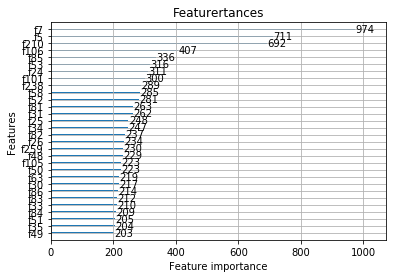

In [17]:
plt.figure()
lgb.plot_importance(gbm, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [26]:
booster = gbm.booster
importance = booster.feature_importance(importance_type='split')
feature_name = booster.feature_name()
# for (feature_name,importance) in zip(feature_name,importance):
#     print (feature_name,importance) 
feature_importance = pd.DataFrame({'feature_name':feature_name,'importance':importance} )

AttributeError: 'Booster' object has no attribute 'booster'

In [18]:
print('Feature importances:', list(gbm.feature_importance()))

Feature importances: [15, 6, 20, 3, 711, 16, 974, 12, 7, 24, 10, 16, 10, 24, 12, 17, 33, 11, 11, 30, 72, 33, 38, 311, 248, 234, 133, 148, 148, 217, 262, 201, 210, 247, 204, 229, 203, 223, 205, 281, 316, 126, 99, 106, 153, 285, 4, 15, 43, 57, 219, 30, 19, 27, 18, 22, 34, 17, 30, 42, 71, 45, 48, 49, 75, 70, 46, 121, 263, 237, 212, 209, 336, 214, 17, 7, 19, 50, 49, 16, 12, 8, 14, 28, 28, 70, 58, 132, 300, 91, 96, 89, 223, 407, 30, 23, 11, 58, 22, 32, 57, 23, 10, 14, 7, 16, 13, 29, 5, 10, 15, 12, 17, 11, 7, 11, 15, 14, 15, 26, 8, 36, 6, 11, 23, 7, 5, 12, 1, 30, 31, 14, 24, 26, 16, 43, 24, 20, 36, 7, 2, 22, 12, 36, 10, 11, 16, 4, 51, 19, 15, 43, 31, 1, 3, 4, 6, 5, 18, 10, 4, 6, 27, 15, 38, 62, 30, 18, 21, 51, 34, 70, 164, 6, 6, 8, 5, 3, 6, 21, 16, 11, 12, 8, 13, 12, 4, 6, 10, 105, 22, 128, 68, 73, 47, 42, 98, 692, 23, 16, 30, 29, 96, 60, 47, 73, 18, 25, 7, 54, 28, 37, 21, 51, 15, 6, 13, 40, 36, 35, 28, 142, 182, 74, 111, 289, 75, 85, 84, 30, 47, 100, 87, 52, 46, 51, 29, 38, 61, 53, 112, 3, 

In [19]:
feature_imp = pd.DataFrame({
        'column': gbm.feature_name(),
        'importance': gbm.feature_importance(),
    })

In [20]:
feature_imp.sort_values(by="importance",ascending=False)

,column,importance
6,f7,974
4,f5,711
197,f210,692
93,f106,407
72,f85,336
40,f53,316
23,f24,311
88,f101,300
225,f238,289
45,f58,285


In [21]:
imp_fea = feature_imp.sort_values(by="importance",ascending=False)

In [23]:
imp150 = imp_fea.reset_index().loc[:150, "column"]

In [24]:
imp150

0        f7
1        f5
2      f210
3      f106
4       f85
5       f53
6       f24
7      f101
8      f238
9       f58
10      f52
11      f81
12      f31
13      f25
14      f34
15      f82
16      f26
17     f259
18      f48
19     f105
20      f50
21      f63
22      f30
23      f86
24      f83
25      f33
26      f84
27      f51
28      f35
29      f49
       ... 
121    f224
122    f231
123    f134
124    f156
125    f151
126    f283
127    f232
128     f69
129    f281
130    f183
131     f22
132     f17
133    f284
134    f112
135    f143
136    f165
137     f20
138     f71
139    f242
140    f107
141    f213
142     f64
143    f142
144    f179
145    f214
146    f249
147    f120
148    f233
149     f97
150     f96
Name: column, Length: 151, dtype: object

In [25]:
train_nan = train_set.loc[:, imp150].isnull().sum(axis=1)

In [32]:
train_set = train_set[train_nan<70]

In [33]:
np.sum(train_nan>70)

61794

In [34]:
train_label = train_label[train_nan<70]

In [35]:
train_set.shape

(639688, 285)

In [37]:
eva_nan = eva_set.loc[:, imp150].isnull().sum(axis=1)

In [38]:
eva_set = eva_set[eva_nan<70]

In [39]:
eva_label = eva_label[eva_nan<70]

In [40]:
eva_set.shape

(144093, 285)

In [41]:
lgb_train=lgb.Dataset(train_set,train_label,free_raw_data=False)
lgb_valid=lgb.Dataset(eva_set,eva_label,reference=lgb_train,free_raw_data=False)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 128,
          'early_stopping_round': 30
}

In [42]:
gbm=lgb.train(params, lgb_train, num_boost_round=2000, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=500)

D:\anaconda\lib\site-packages\lightgbm\engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[65]	valid_set's auc: 0.982957	valid_set's atec_metric: 0.67485


In [43]:
df_test = pd.read_csv("E:\\leonhardt\\mayi\\data\\test_a.csv")

In [44]:
df_test.drop(["date","id"],axis=1, inplace=True)

In [45]:
df_test.drop(col_null, axis=1, inplace=True)

In [46]:
y_preds = gbm.predict(df_test)

In [47]:
y_preds.shape

(491668,)

In [49]:
np.savetxt("E:\\leonhardt\\mayi\\mayi\\ipython\\prediction/lgb_kaggle_imp150.txt", y_preds, delimiter=',')

In [102]:
updata = pd.DataFrame()
updata["id"] = df_test.index
updata["score"] = y_preds2
updata.to_csv("E:\\leonhardt\\mayi\\mayi\\ipython\\update/lgb_imp.csv", index=None)

In [50]:
imp100 = imp_fea.reset_index().loc[:100, "column"]

In [51]:
imp100_ = list(imp100.values)

In [52]:
imp100_

['f7',
 'f5',
 'f210',
 'f106',
 'f85',
 'f53',
 'f24',
 'f101',
 'f238',
 'f58',
 'f52',
 'f81',
 'f31',
 'f25',
 'f34',
 'f82',
 'f26',
 'f259',
 'f48',
 'f105',
 'f50',
 'f63',
 'f30',
 'f86',
 'f83',
 'f33',
 'f84',
 'f51',
 'f35',
 'f49',
 'f32',
 'f235',
 'f185',
 'f260',
 'f57',
 'f29',
 'f28',
 'f262',
 'f234',
 'f27',
 'f100',
 'f204',
 'f266',
 'f263',
 'f54',
 'f80',
 'f253',
 'f237',
 'f56',
 'f202',
 'f244',
 'f55',
 'f209',
 'f270',
 'f103',
 'f215',
 'f102',
 'f104',
 'f261',
 'f278',
 'f245',
 'f240',
 'f241',
 'f265',
 'f290',
 'f77',
 'f239',
 'f236',
 'f218',
 'f206',
 'f21',
 'f73',
 'f78',
 'f98',
 'f184',
 'f205',
 'f264',
 'f282',
 'f279',
 'f178',
 'f251',
 'f291',
 'f216',
 'f110',
 'f99',
 'f296',
 'f62',
 'f113',
 'f222',
 'f252',
 'f246',
 'f226',
 'f161',
 'f182',
 'f248',
 'f90',
 'f91',
 'f76',
 'f75',
 'f207',
 'f217']

In [58]:
lgb_train=lgb.Dataset(train_set,train_label,free_raw_data=False, categorical_feature=imp100_)
lgb_valid=lgb.Dataset(eva_set,eva_label,reference=lgb_train,free_raw_data=False,categorical_feature=imp100_)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 128,
          'early_stopping_round': 30
}

In [59]:
# gbm=lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=500, categorical_feature=imp100_)

D:\anaconda\lib\site-packages\lightgbm\engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\basic.py:681: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[129]	valid_set's auc: 0.984879	valid_set's atec_metric: 0.632733


In [61]:
gbm=lgb.train(params, lgb_train, num_boost_round=1300, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=500,categorical_feature=imp100_)

[500]	valid_set's auc: 0.989871	valid_set's atec_metric: 0.674099
[1000]	valid_set's auc: 0.991741	valid_set's atec_metric: 0.675976


In [62]:
y_preds2 = gbm.predict(df_test)

In [65]:
np.savetxt("E:\\leonhardt\\mayi\\mayi\\ipython\\prediction/lgb_kaggle_imp100.txt", y_preds2, delimiter=',')

In [64]:
y_preds2

array([5.26309357e-05, 4.05642182e-04, 1.13310711e-05, ...,
       7.28640171e-06, 3.06772291e-05, 2.29305406e-05])

In [66]:
from imblearn.under_sampling import RandomUnderSampler

In [68]:
np.sum(train_label==0)

634742

In [71]:
rus_trian = RandomUnderSampler(ratio={0:49000, 1:4900}, random_state=47)
train_rus, label_rus = rus_trian.fit_sample(train_set.fillna(-1), train_label)

In [80]:
imp150 = list(imp150)

In [81]:
train_rus_set = lgb.Dataset(train_set,train_label,free_raw_data=False, categorical_feature=imp150)
eval_rus_set = lgb.Dataset(eva_set.fillna(-1),eva_label,reference=lgb_train,free_raw_data=False,categorical_feature=imp150)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 128,
          'early_stopping_round': 30
}

In [82]:
gbm_rus = lgb.train(params, lgb_train, num_boost_round=1300, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=500,categorical_feature=imp150)

D:\anaconda\lib\site-packages\lightgbm\engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
D:\anaconda\lib\site-packages\lightgbm\basic.py:1038: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f110', 'f112', 'f113', 'f120', 'f134', 'f142', 'f143', 'f148', 'f151', 'f156', 'f161', 'f164', 'f165', 'f17', 'f177', 'f178', 'f179', 'f182', 'f183', 'f184', 'f185', 'f20', 'f202', 'f204', 'f205', 'f206', 'f207', 'f208', 'f209', 'f21', 'f210', 'f213', 'f214', 'f215', 'f216', 'f217', 'f218', 'f22', 'f222', 'f224', 'f226', 'f23', 'f230', 'f231', 'f232', 'f233', 'f234', 'f235', 'f236', 'f237', 'f238', 'f239', 'f24', 'f240', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247', 'f248', 'f249', 'f25', 'f250', 'f251', 'f252', 'f253', 'f259', 'f26', 'f260', 'f261', '

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[142]	valid_set's auc: 0.979787	valid_set's atec_metric: 0.638213


In [85]:
y_preds3_early = gbm_rus.predict(df_test.fillna(-1))

In [86]:
np.savetxt("E:\\leonhardt\\mayi\\mayi\\ipython\\prediction/lgb_kaggle_imp150_rus.txt", y_preds3_early, delimiter=',')

In [87]:
train_rus_set = lgb.Dataset(train_set,train_label,free_raw_data=False, categorical_feature=imp150)
eval_rus_set = lgb.Dataset(eva_set.fillna(-1),eva_label,reference=lgb_train,free_raw_data=False,categorical_feature=imp150)
params = {'boosting_type': 'gbdt',
          'objective': 'binary', 
          'metric': 'auc', 
          'device': 'cpu', 
          'verbose': 0, 
          'learning_rate': 0.01, 
          'bagging_fraction': 0.8,
          'bagging_freq': 5,
          'feature_fraction': 0.9,
          'lambda_l1': 0.006, 
          'num_leaves': 128
#           'early_stopping_round': 30
}

In [89]:
gbm_rus_1 = lgb.train(params, lgb_train, num_boost_round=1300, valid_sets=lgb_valid, valid_names='valid_set', feval=atec_metric, verbose_eval=500,categorical_feature=imp150)

[500]	valid_set's auc: 0.987911	valid_set's atec_metric: 0.665691
[1000]	valid_set's auc: 0.991833	valid_set's atec_metric: 0.681381


In [90]:
y_preds3 = gbm_rus.predict(df_test.fillna(-1))

In [91]:
np.savetxt("E:\\leonhardt\\mayi\\mayi\\ipython\\prediction/lgb_kaggle_imp150_rus1300.txt", y_preds3, delimiter=',')

In [ ]:
y_pr